Parameters to set:

up, down, left, right


## Images

In [24]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import find_boundaries
from scipy import ndimage
from skimage import exposure
from skimage import color
from skimage import filters
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting
from DeCRISP import decrisp as dcp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Read in the membrane segmentation
with open('./data/20210928Sg2HBNEB_masks_mem.npy', 'rb') as m:
    masks_mem = np.load(m)

In [26]:
n_channels = 2
n_cycles = 5

In [27]:
with open('./data/20210928Sg2HBNEB_registered.npy', 'rb') as f:
    X = np.load(f)

In [28]:
X.shape

(10, 1, 1792, 2304)

In [29]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=160)
#     plt.imshow(X[i, 0,])

In [30]:
up = 110
down = 1790
left = 10
right = 2300

Xcenter = dcp.remove_border(X, up=up, down=down, left=left, right=right)

In [31]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=160)
# #     plt.imshow(find_boundaries(masks_mem[1000:, ]))
#     plt.imshow(Xcenter[i, 0,])
#     plt.title(i+1)

## Codebook

The most important is to make sure the codebook and the images are of the same order

In [32]:
codebook = pd.read_csv('./data/CRISPRmap_pilot_codebook_default.csv', dtype=np.int, header=None)
codebook = np.array(codebook)
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [33]:
codebook.shape

(10, 10)

## Background subtraction

In [34]:
Xcenter.shape

(10, 1, 1680, 2290)

In [35]:
# Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,33,33])
Xnorm = Xcenter - filters.gaussian(Xcenter, sigma=19, mode='nearest', preserve_range=True)
Xnorm = np.clip(Xnorm, 0, Xnorm.max())
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=100)
#     fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
#     ax = axes.ravel()

#     ax[0].imshow(Xcenter[i, 0, 1000:, ])
#     ax[0].set_title(f'Before {i+1}')

#     ax[1].imshow(Xnorm[i, 0, 1000:, ])
#     ax[1].set_title(f'After {i+1}')

#     for a in ax:
#         a.axis('off')

#     plt.show()
# Xnorm = bardensr.preprocessing.minmax(Xnorm)
Xnorm = (Xnorm - Xnorm.min()) / Xnorm.max()
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=100)
#     fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
#     ax = axes.ravel()

#     ax[0].imshow(Xcenter[i, 0, 1000:, ])
#     ax[0].set_title(f'Before {i+1}')

#     ax[1].imshow(Xnorm[i, 0, 1000:, ])
#     ax[1].set_title(f'After {i+1}')

#     for a in ax:
#         a.axis('off')

#     plt.show()

## Thresholding

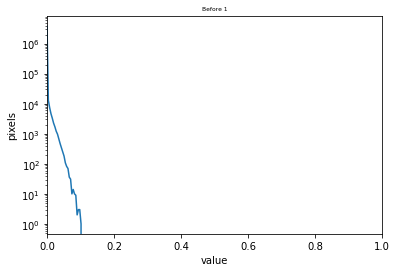

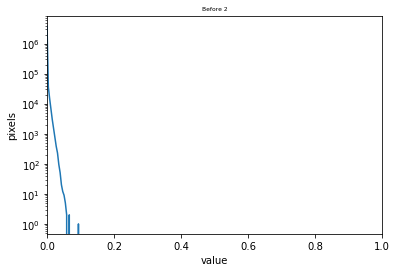

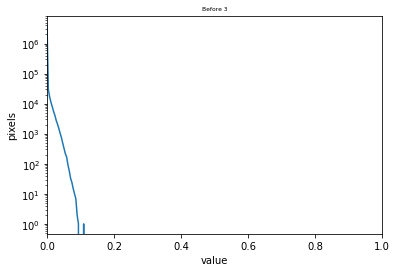

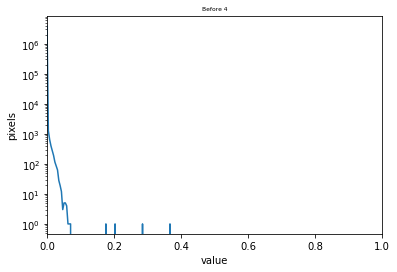

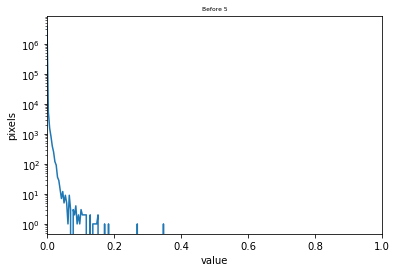

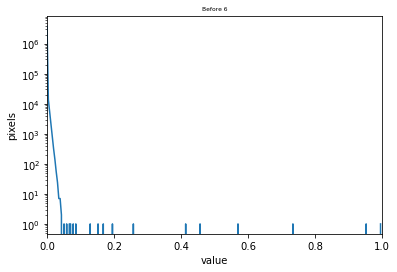

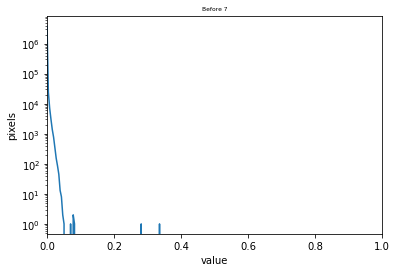

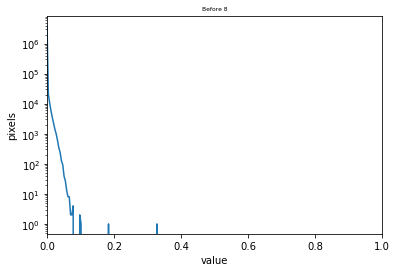

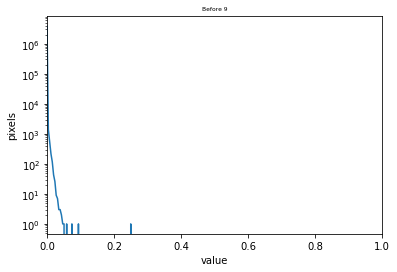

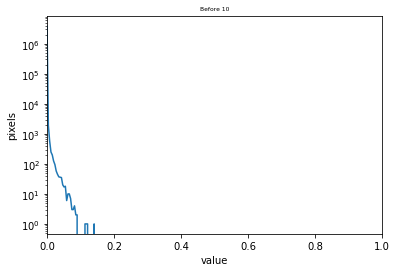

In [36]:
# Distributions before thresholding
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"Before {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

In [37]:
# Xthresh = Xnorm.copy()
# for i in range(Xthresh.shape[0]):
#     Xthresh[i, 0] = exposure.match_histograms(Xnorm[i, 0], Xnorm[1, 0])  # match histogram to Xnorm[1, 0]

In [38]:
Xcenter.shape

(10, 1, 1680, 2290)

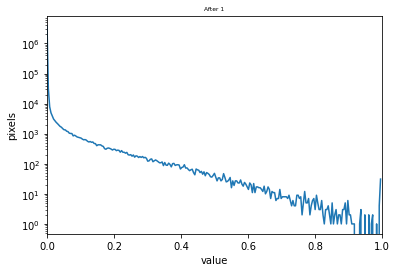

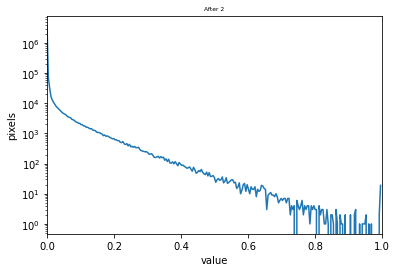

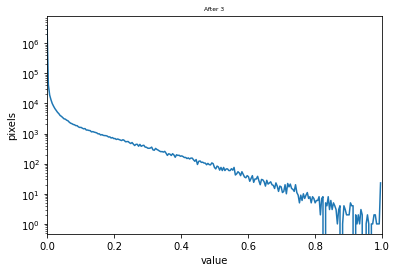

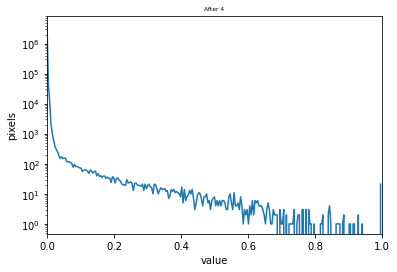

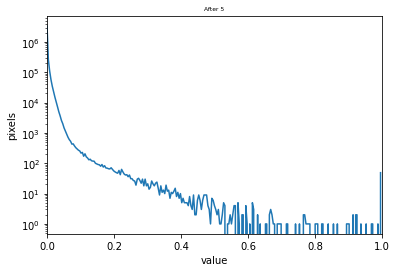

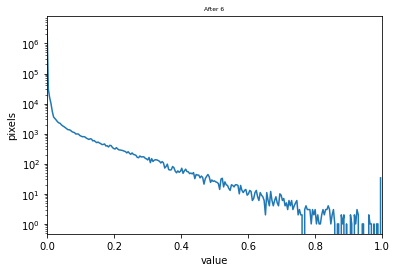

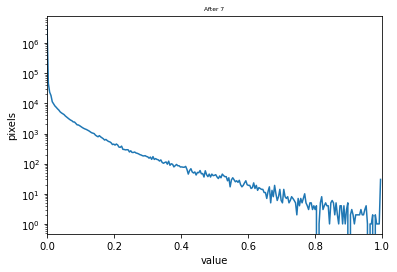

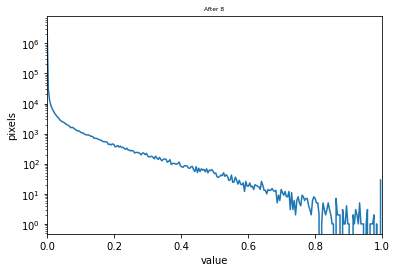

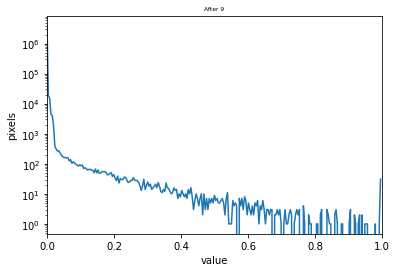

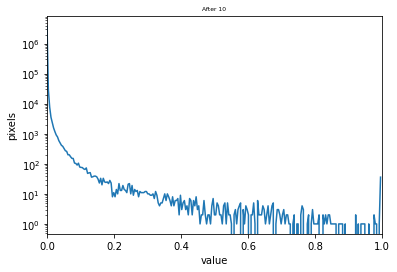

In [39]:
# Don't split this cell
upper = dcp.upper_thresh(Xnorm, n_channels=n_channels, n_cycles=n_cycles, min_bin=5)
Xthresh = dcp.upper_collapse(Xnorm, upper)
Xthresh = bardensr.preprocessing.minmax(Xthresh)

# After
for i in range(Xthresh.shape[0]):
    histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"After {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

# Xthresh = dcp.lower_thresh(Xthresh)
# residual = 0.01
# Xthresh[Xthresh < residual] = 0
# Xthresh = Xthresh > residual

In [40]:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=100)
#     fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
#     ax = axes.ravel()

# #     ax[0].imshow(find_boundaries(masks_mem[up:down, left:right][1000:, ]), alpha=0.5)
# #     ax[0].imshow(Xcenter[i, 0, 1000:, ])
#     ax[0].imshow(Xnorm[i, 0, 1000:, ])
#     ax[0].set_title(f'Before {i+1}')

# #     ax[1].imshow(find_boundaries(masks_mem[up:down, left:right][1000:, ]), alpha=0.5)
# #     ax[1].imshow(Xthresh[i, 0, 400:600, 400:600])
#     ax[1].imshow(Xthresh[i, 0, 1000:, ])
#     ax[1].set_title(f'After {i+1}')

#     for a in ax:
#         a.axis('off')

#     plt.show()

In [41]:
Xthresh[0,0].shape

(1680, 2290)

## Prediction

0.04374182663857927


<Figure size 1200x800 with 0 Axes>

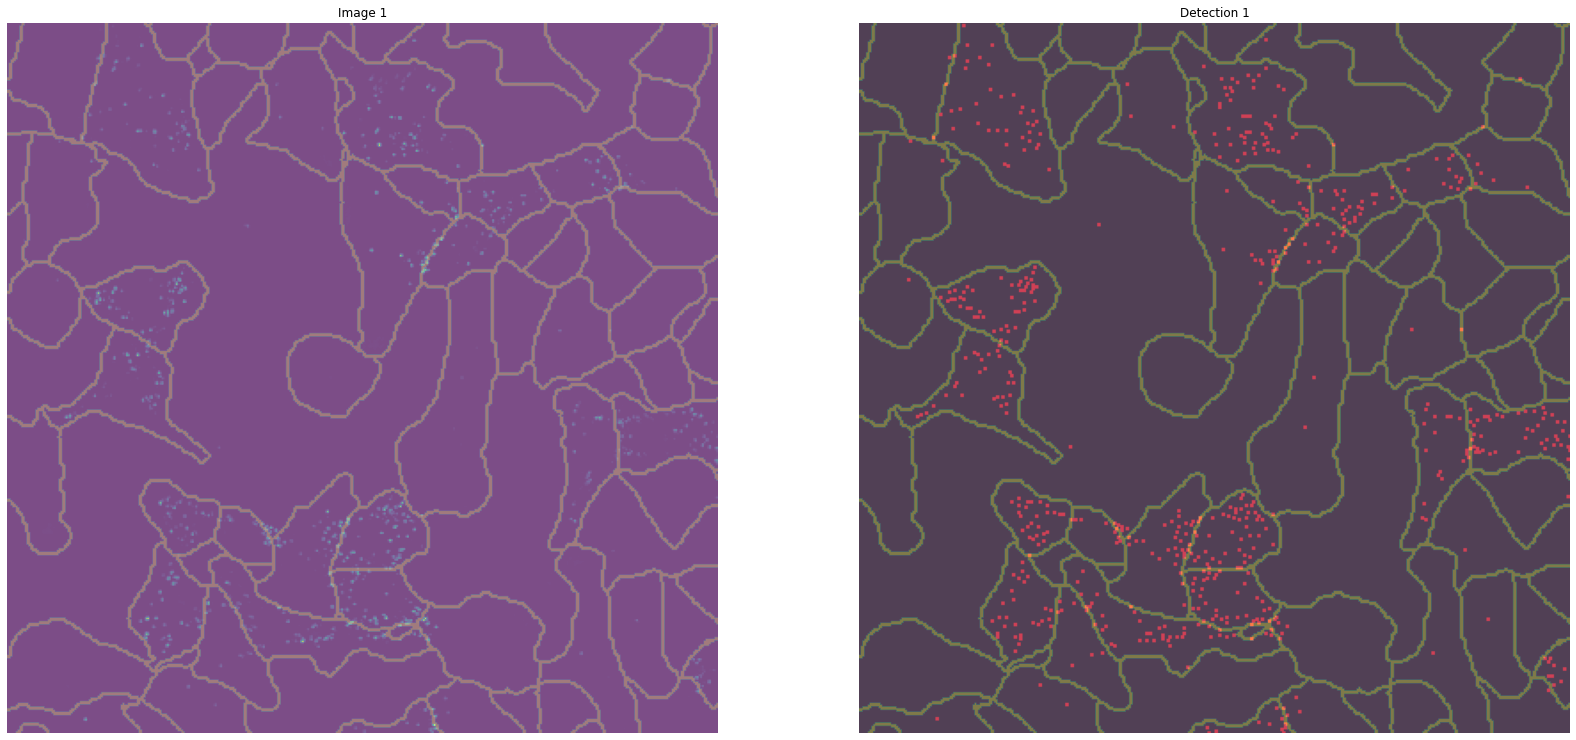

0.12079140521585842


<Figure size 1200x800 with 0 Axes>

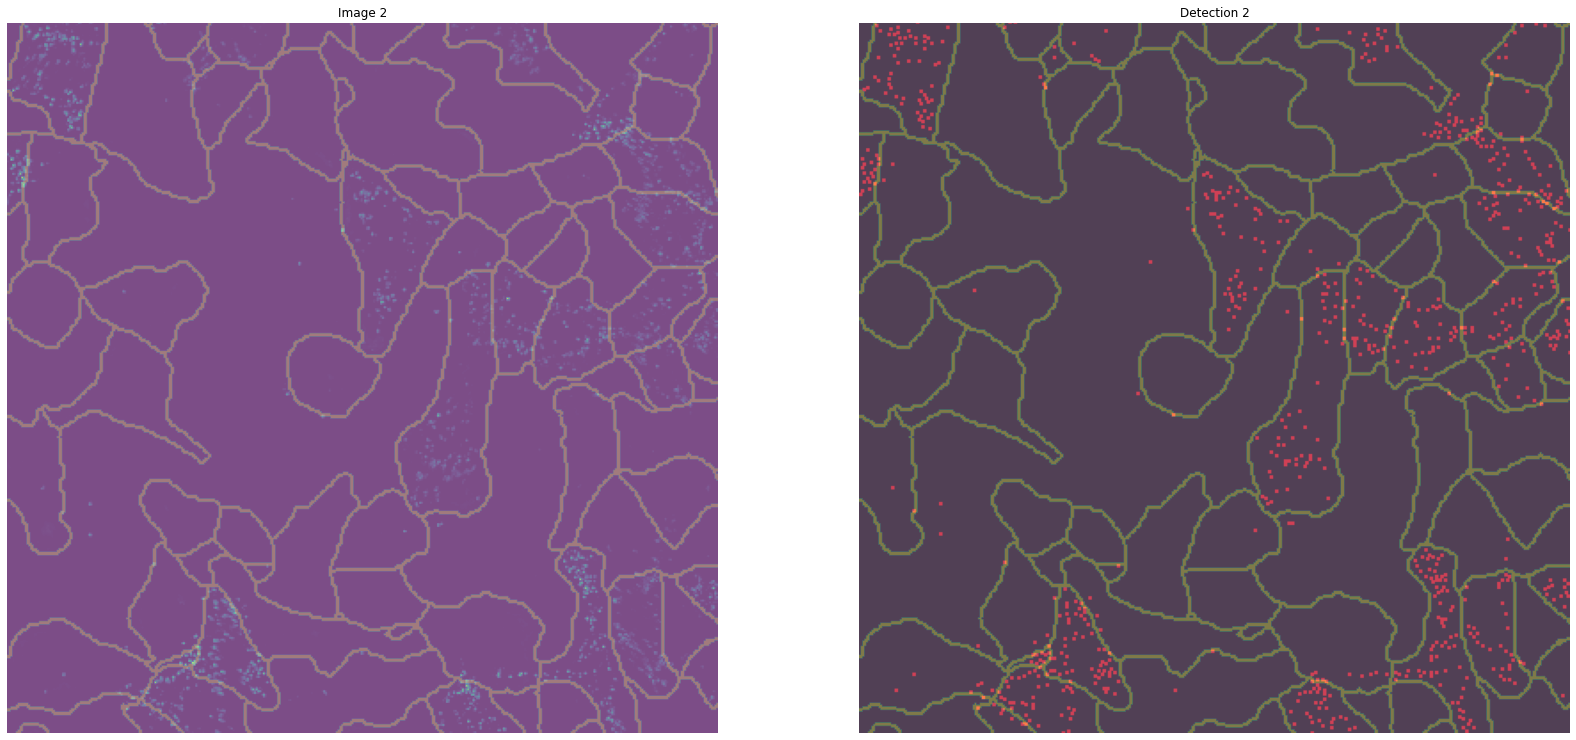

0.14181502312421695


<Figure size 1200x800 with 0 Axes>

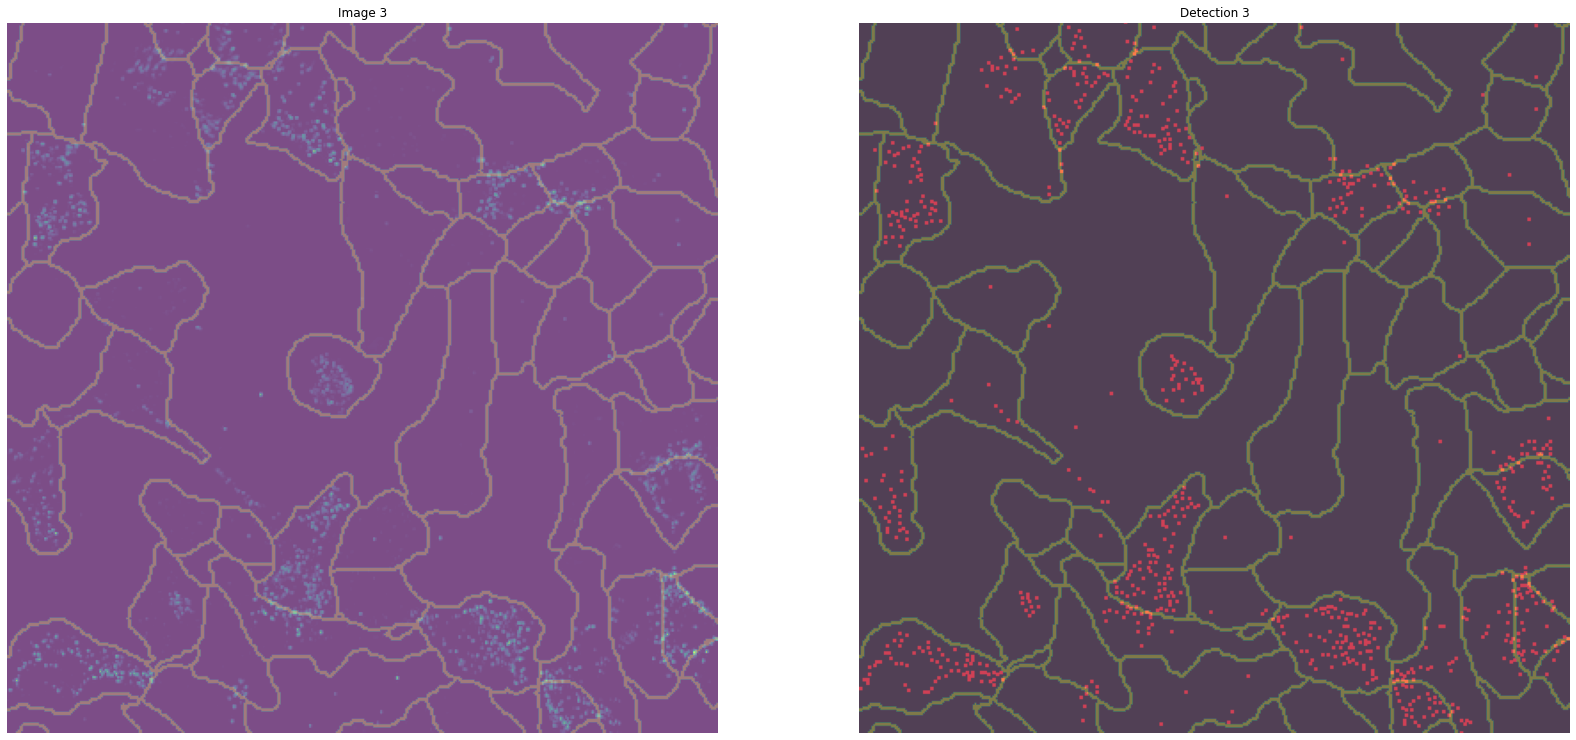

0.005615416816435746


<Figure size 1200x800 with 0 Axes>

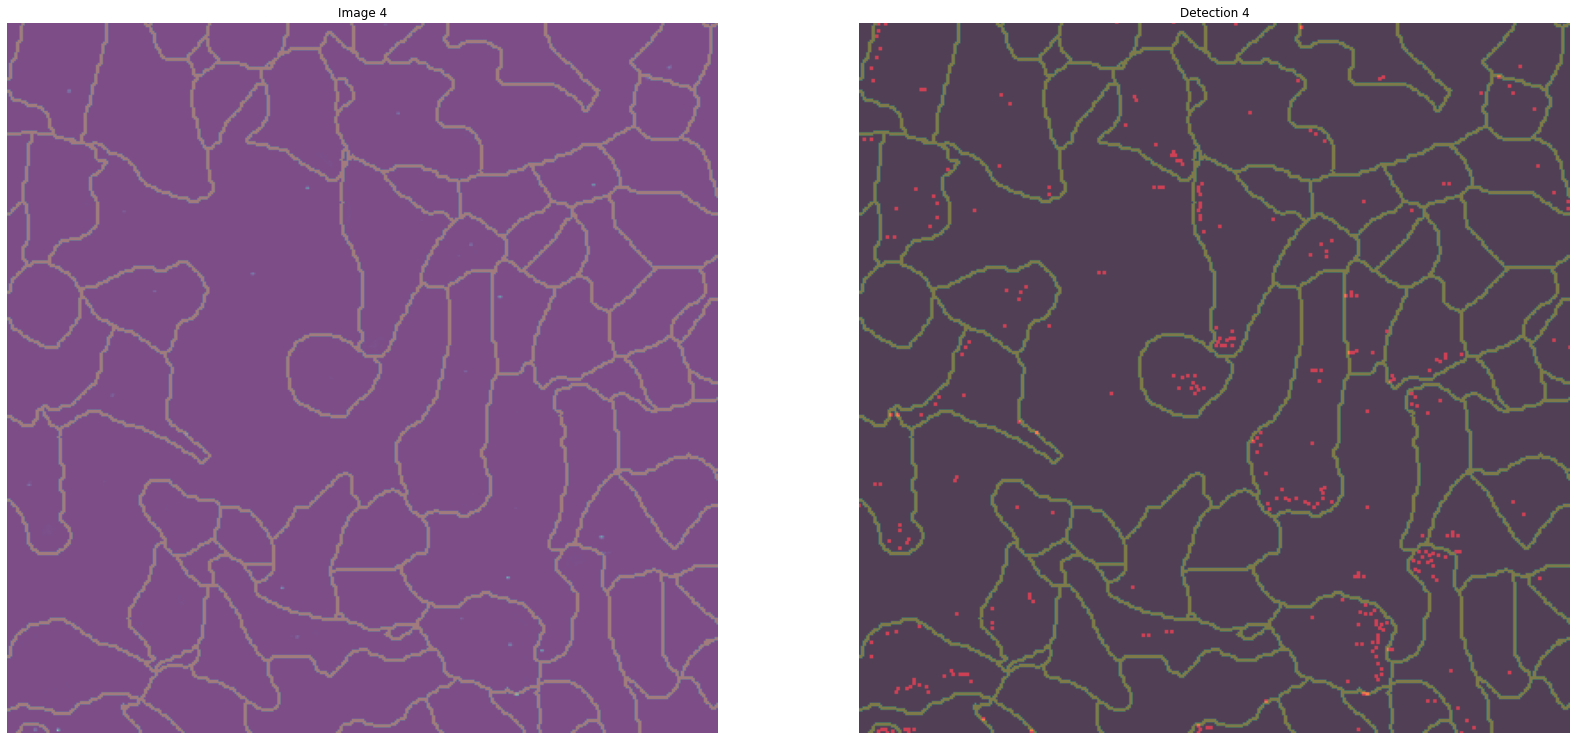

0.02896261071786267


<Figure size 1200x800 with 0 Axes>

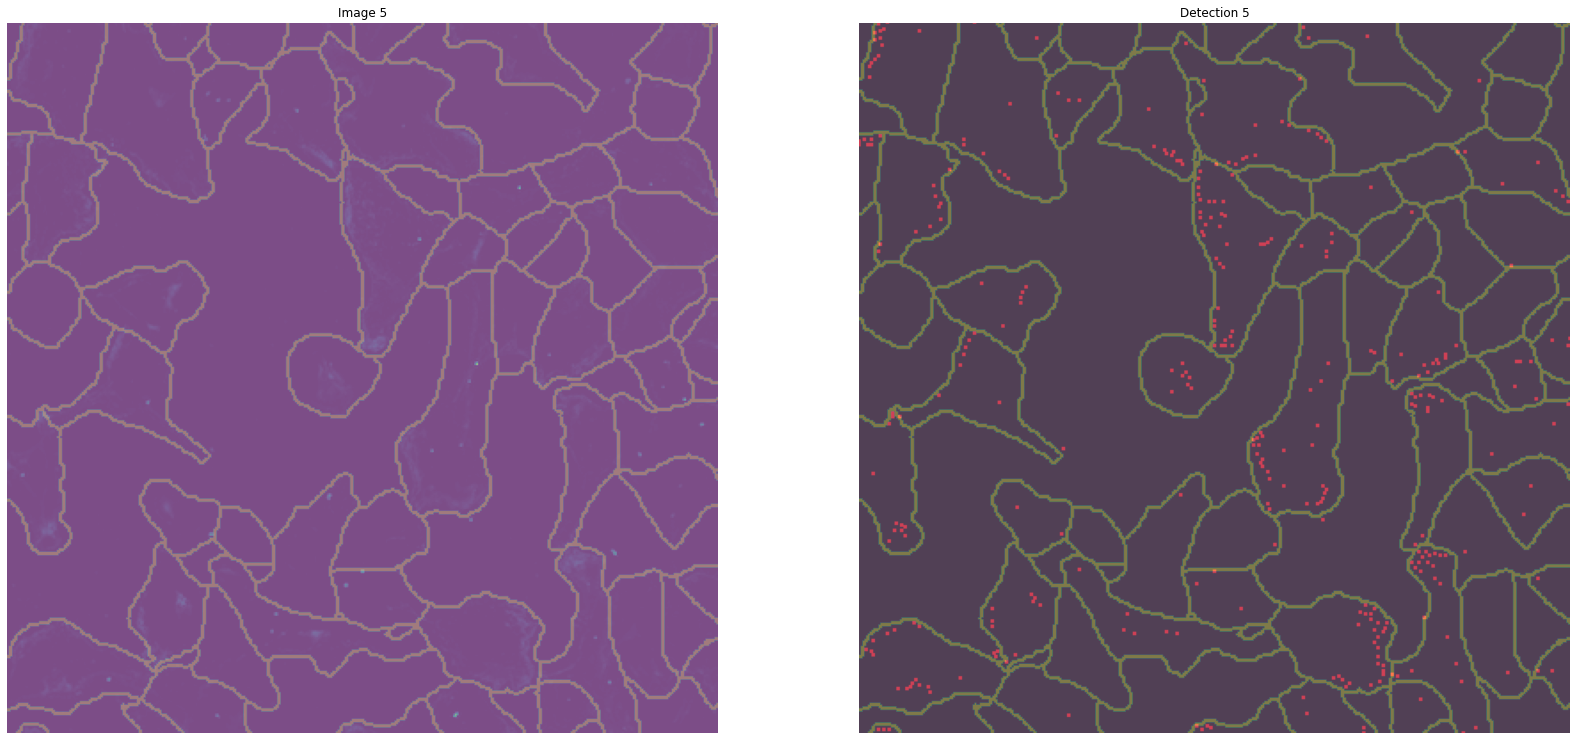

0.0548185950890183


<Figure size 1200x800 with 0 Axes>

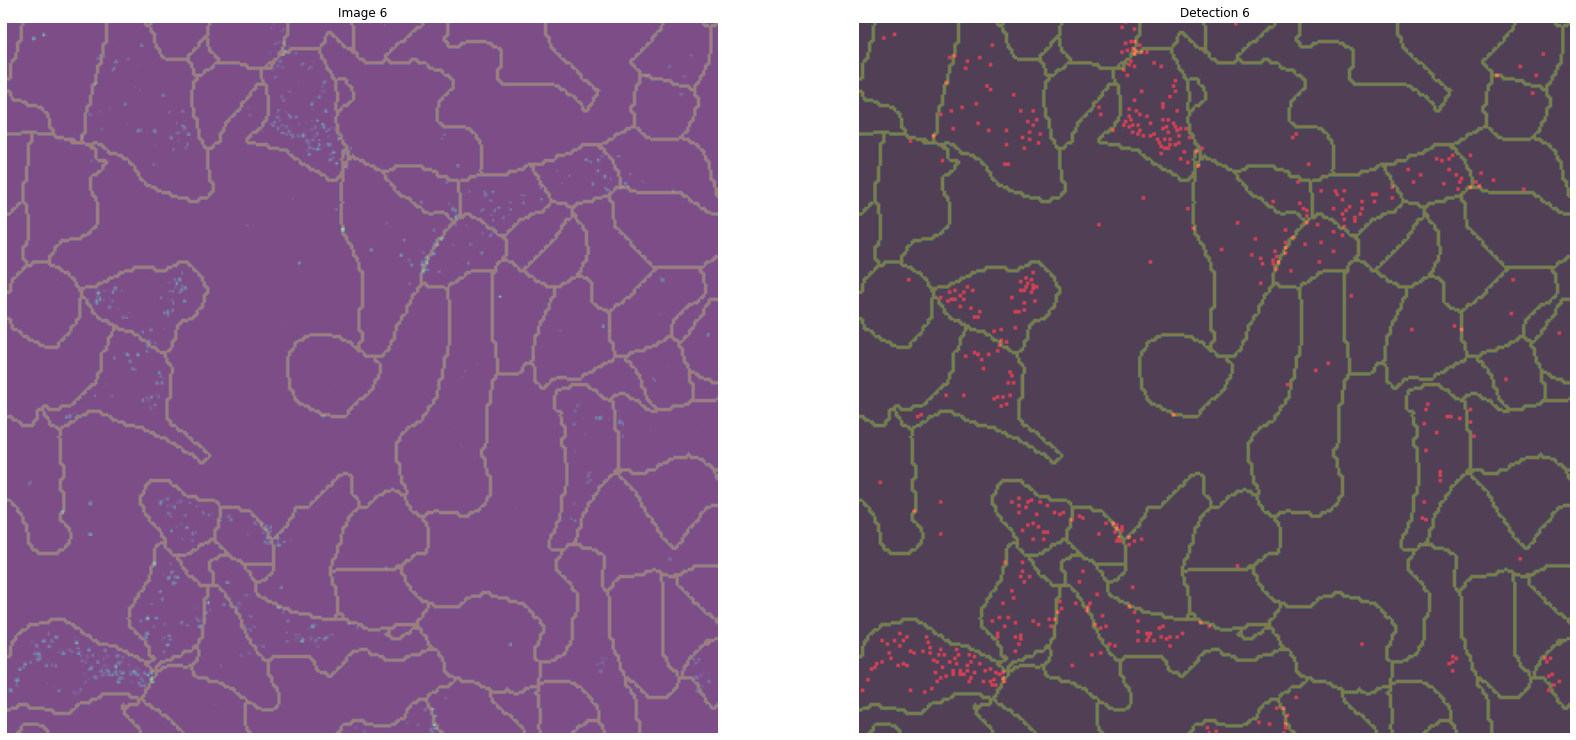

0.09763886034488578


<Figure size 1200x800 with 0 Axes>

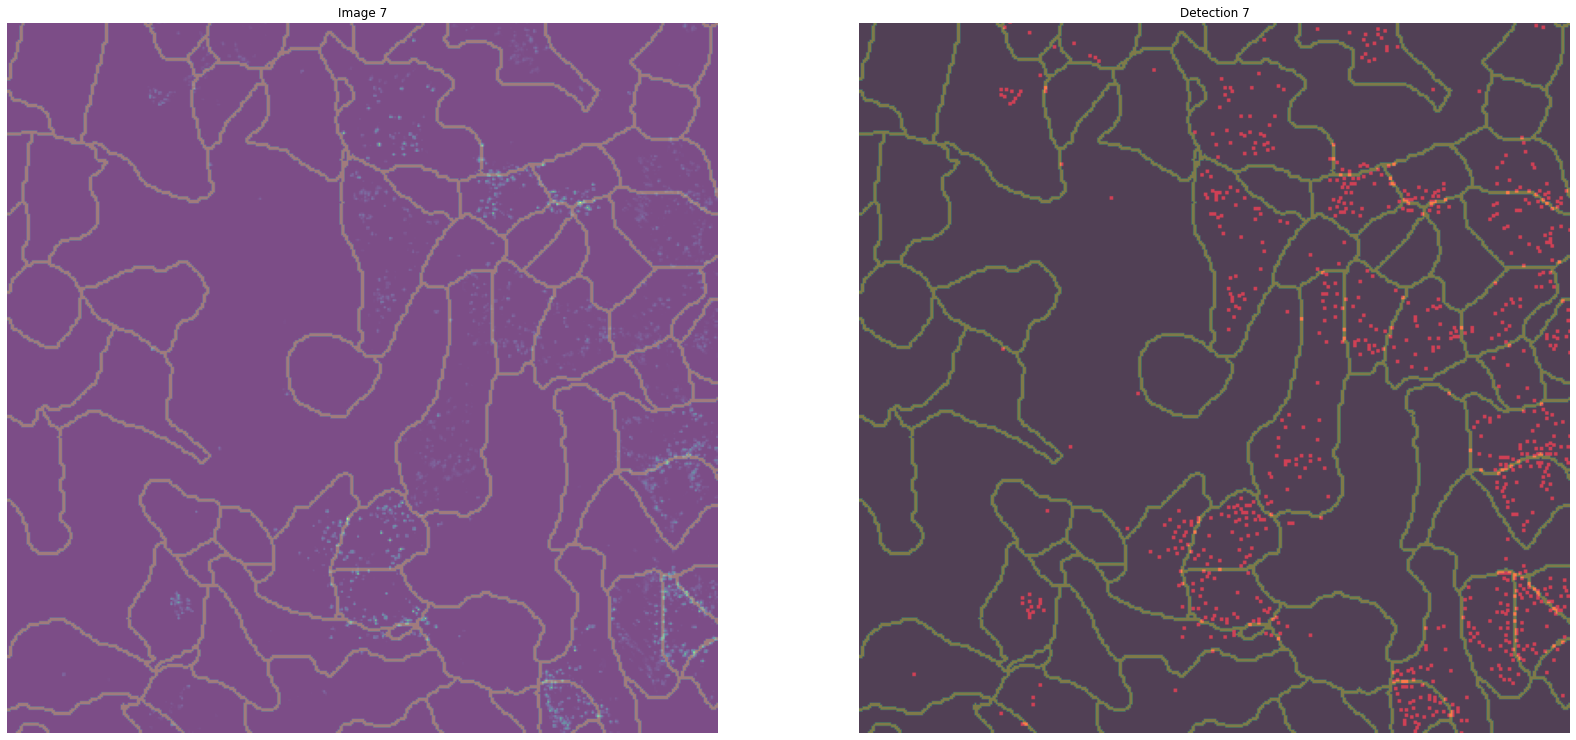

0.08196823053061918


<Figure size 1200x800 with 0 Axes>

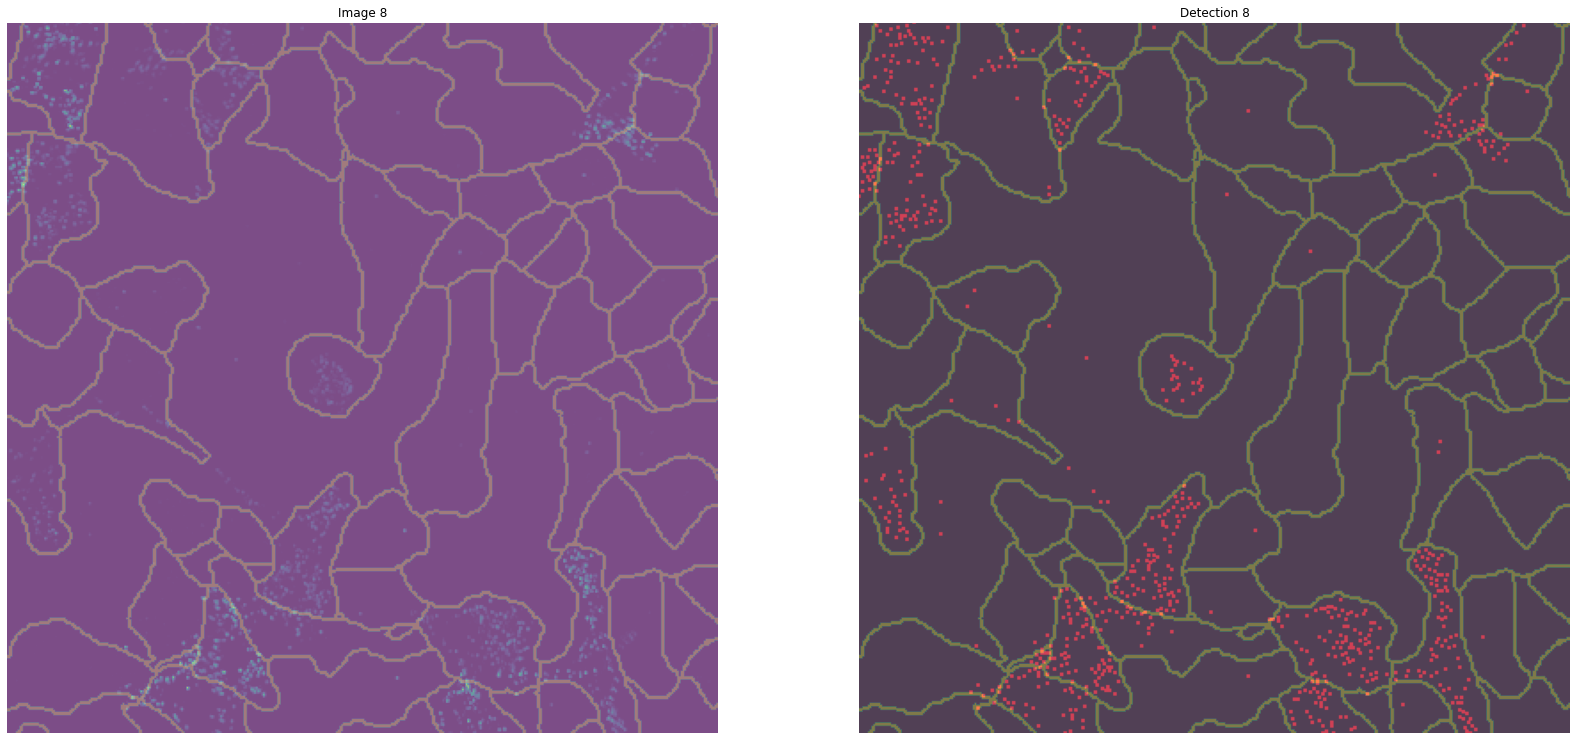

0.006207732949405909


<Figure size 1200x800 with 0 Axes>

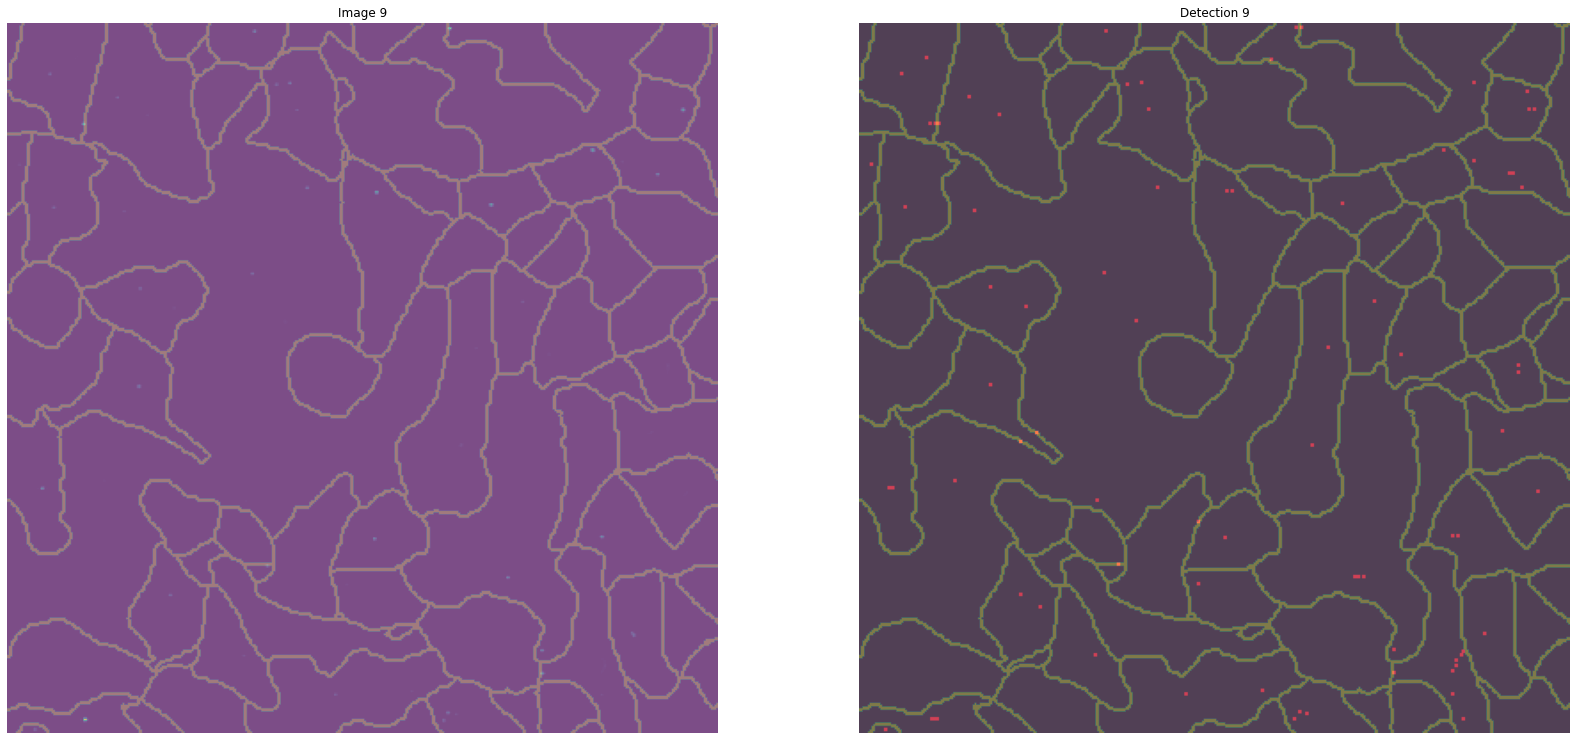

0.0050549395382404015


<Figure size 1200x800 with 0 Axes>

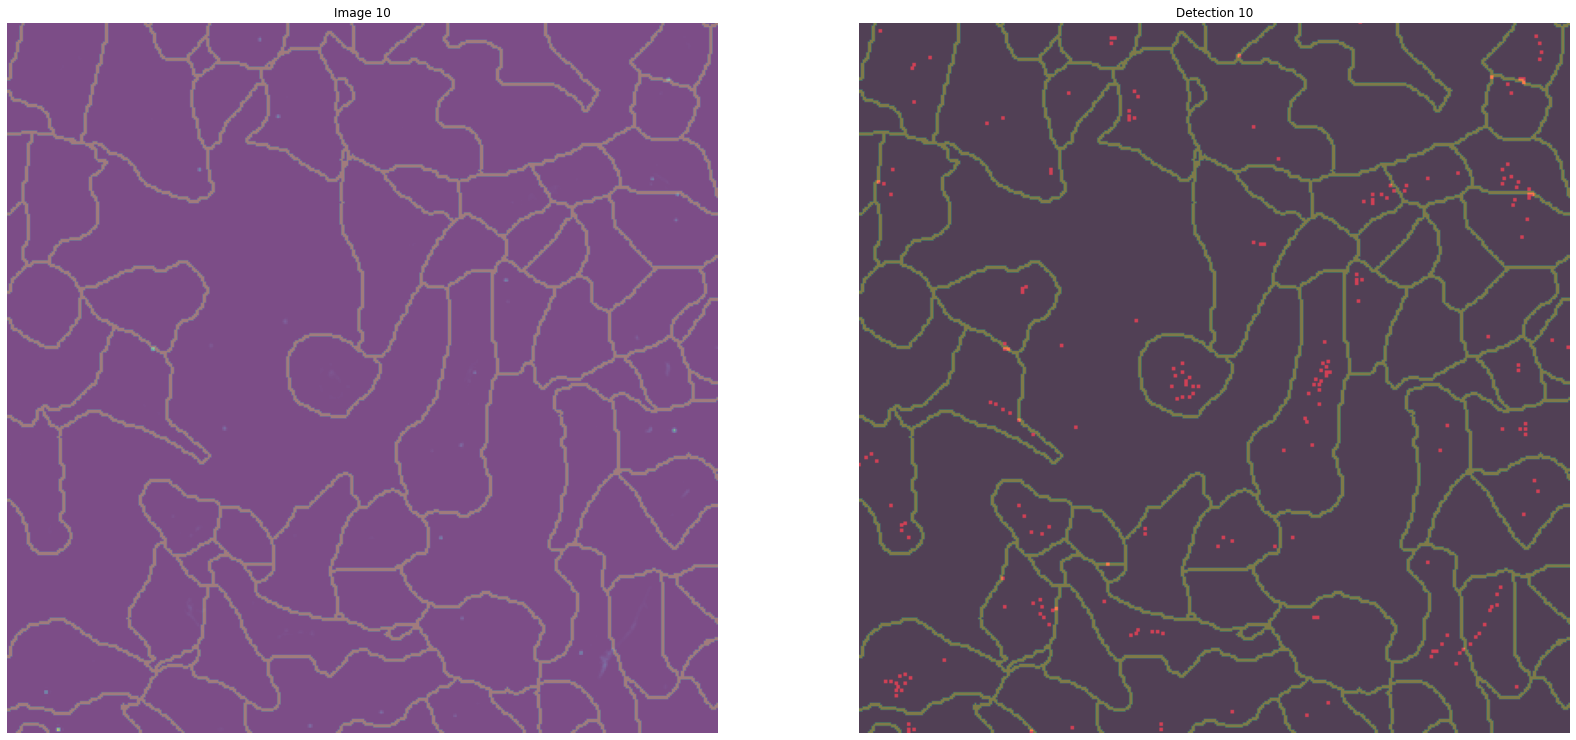

In [60]:
# cell_table = dcp.create_celltable(Xthresh, masks_mem, up_adjust=up, left_adjust=left)
# cell_table

spotMask_all = []

cell_table = np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0]))

all_coords = np.zeros((0, 2))
# spotMask = np.zeros((Xthresh.shape[2], Xthresh.shape[3], 3))

for k in range(Xthresh.shape[0]):  # for the kth image
# for k in range(2):  # for the kth image
    
    spotMask = np.zeros((Xthresh.shape[2], Xthresh.shape[3], 3))
    
    max_fil = ndimage.maximum_filter(Xthresh[k, 0], size=(3, 3), mode='nearest')
#     h = max_fil.mean() + max_fil.std() * 4
    h = np.percentile(Xthresh[k, 0].ravel(), 99)
    print(h)
#     max_fil[(max_fil > Xthresh[k, 0]) || (max_fil < h)] = 0

    # Get the positions of the maxima
    coords = np.argwhere((max_fil == Xthresh[k, 0]) & (max_fil >= h))
    all_coords = np.r_[all_coords, coords]
    
#     spotMask = np.zeros((*masks_mem.shape, 3))
#     plt.figure(dpi=100)
#     for i in range(len(coords)):
# #         xindex = int(np.round(coords[i][2] + left))
# #         yindex = int(np.round(coords[i][1] + up))
#         xindex = int(np.round(coords[i][2]))
#         yindex = int(np.round(coords[i][1]))
#         spotMask[yindex-1:yindex+2, xindex-1:xindex+2] = (1, 0, 0)
#     plt.figure(dpi=100)
#     plt.imshow(find_boundaries(masks_mem[up:down, left:right][1000:, ]), alpha=0.5)
#     plt.imshow(spotMask[1000:, ], alpha=0.5)
#     plt.title(k+1)
#     plt.axis('image')
    for y, x in coords:
        xindex = int(np.round(x))
        yindex = int(np.round(y))
        spotMask[yindex-1:yindex+1, xindex-1:xindex+1] = (1, 0, 0)


    plt.figure(dpi=200)
    fig, axes = plt.subplots(ncols=2, figsize=(28, 28))
    ax = axes.ravel()

    ax[0].imshow(find_boundaries(masks_mem[up:down, left:right][800:1200, 800:1200]), alpha=0.4)
    ax[0].imshow(Xthresh[k, 0, 800:1200, 800:1200], alpha=0.5)
    ax[0].set_title(f'Image {k+1}')

    ax[1].imshow(find_boundaries(masks_mem[up:down, left:right][800:1200, 800:1200]), alpha=0.5)
    ax[1].imshow(spotMask[800:1200, 800:1200], alpha=0.5)
    ax[1].set_title(f'Detection {k+1}')

    for a in ax:
        a.axis('off')
    plt.show()
    
    spotMask_all.append(spotMask)


    #for _, m1, m2 in coords:
    for m1, m2 in coords:
        m1 = int(np.round(m1))
        m2 = int(np.round(m2))
        mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
        if mem_id>0: # 0 is background
#             cell_table.loc[mem_id, k] += 1
            cell_table[mem_id, k] += 1

In [68]:
# import pickle as pkl
# filehandler = open('./result/crispmap20210928Sg2HBNEB_Xthresh.pkl', 'wb')
# pkl.dump(Xthresh, filehandler)
# filehandler.close()

In [69]:
# test_pkl = pkl.load(open('./result/crispmap20210928Sg2HBNEB_Xthresh.pkl', 'rb'))
# test_pkl.shape

(10, 1, 1680, 2290)

In [44]:
# pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [45]:
cell_table.shape

(1115, 10)

In [76]:
cell_corr = dcp.cal_metric(cell_table, codebook)
corr_thresh = 0.001
alpha = 0.05  
beta = 0.8  # power
thresh_corr_diff = 0.16
cell_id = pd.DataFrame(dcp.argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id['correlation_max'] = dcp.minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_2nd_max'] = dcp.minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_difference'] = cell_id['correlation_max'] - cell_id['correlation_2nd_max']
cell_id['select_by_correlation'] = cell_id['correlation_difference'] > thresh_corr_diff
cell_id['spots_max'] = np.max(cell_table, axis=1)
cell_id['spots_sum'] = np.sum(cell_table, axis=1)
cell_id['spots_needed'] = cell_id['correlation_max'].apply(dcp.sample_size, alpha=alpha, beta=beta)
cell_id['select_by_spots'] = cell_id['spots_sum'] > cell_id['spots_needed']
cell_id['cells_with_spots'] = cell_id['spots_sum'] > 0
cell_id['selected'] = cell_id['select_by_correlation'] & cell_id['select_by_spots']
cell_id['high_spots'] = cell_id['spots_max'] > 24
cell_id['select_by_high_spots'] = cell_id['select_by_correlation'] & cell_id['high_spots']
cell_id.head()

barcode  correlation_max  correlation_2nd_max  correlation_difference  \
0       -1              0.0                  0.0                     0.0   
1       -1              0.0                  0.0                     0.0   
2       -1              0.0                  0.0                     0.0   
3       -1              0.0                  0.0                     0.0   
4       -1              0.0                  0.0                     0.0   

   select_by_correlation  spots_max  spots_sum    spots_needed  \
0                  False        0.0        0.0  31395550336760   
1                  False        0.0        0.0  31395550336760   
2                  False        0.0        0.0  31395550336760   
3                  False        0.0        0.0  31395550336760   
4                  False        0.0        0.0  31395550336760   

   select_by_spots  cells_with_spots  selected  high_spots  \
0            False             False     False       False   
1            False             False     False       False   
2            False             False     False       False   
3            False             False     False       False   
4            False             False     False       False   

   select_by_high_spots  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False

In [47]:
# color_dict = {
#     0: (0,0,255),
#     1: (0,255,0),
#     2: (255, 0, 0),
#     3: (0,255,255),
#     4: (255,0,255),
#     5: (255,255,0),
#     6: (255,127,0),
#     7: (0,127,0),
#     8: (127,0,0),
#     9: (255,255,255)
# }

# for m1, m2 in all_coords:
#     m1 = int(np.round(m1))
#     m2 = int(np.round(m2))
#     all_mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
#     if mem_id>0: # 0 is background
# #             cell_table.loc[mem_id, k] += 1
#         cell_table[mem_id, k] += 1

# all_spotMask = np.zeros((Xthresh.shape[2], Xthresh.shape[3], 3), dtype=np.uint8)
# for y, x in all_coords:
#     xindex = int(np.round(x))
#     yindex = int(np.round(y))
#     spot_barcode = cell_id.barcode[masks_mem[yindex+up, xindex+left]]
#     if spot_barcode >= 0: # barcodes start from 0
#         all_spotMask[yindex-1:yindex+1, xindex-1:xindex+1] = color_dict[spot_barcode]

# all_spotMask[find_boundaries(masks_mem[up:down, left:right])] = (127, 127, 127)

# plt.figure(dpi=300)

# # plt.imshow(find_boundaries(masks_mem[up:down, left:right]), alpha=0.5)
# plt.imshow(all_spotMask, origin='lower')

In [48]:
# all_spotMask[find_boundaries(masks_mem[up:down, left:right])]

In [78]:
print("The number of cells:", cell_id.shape[0]-1)
cell_no_spots = cell_id[cell_id.barcode==-1].shape[0]
print("The number of cells with no detected spots:", cell_no_spots)
print("Percent of cells with no detected spots:", cell_no_spots / (cell_id.shape[0] -1))
double_infected = cell_id.shape[0] -1 - cell_no_spots - np.sum(cell_id.select_by_correlation)
print("The number of double-infected cells:", double_infected)
print("Percent of double-infected cells:", double_infected / (cell_id.shape[0] -1))
low_spots = cell_id.shape[0] - 1 - np.sum(cell_id.select_by_spots)
# print("The number of cells that do not have enough spots to calculate a significant correlation or no spots:", low_spots)
# print("Percent of cells that do not have enough spots to calculate a significant correlation or no spots:", low_spots / (cell_id.shape[0] -1))
print("The number of cells that do not have enough spots to calculate a significant correlation:", low_spots - cell_no_spots)
print("Percent of cells that do not have enough spots to calculate a significant correlation:", (low_spots- cell_no_spots) / (cell_id.shape[0] -1))
print("The number of cells selected after removing double infection and low number of spots:", np.sum(cell_id.selected))
print("Percent of cells selected after removing double infection and low number of spots:", np.sum(cell_id.selected) / (cell_id.shape[0] -1))
print("Percent of cells selected by high number of spots (>24):", np.sum(cell_id.select_by_high_spots) / (cell_id.shape[0] -1))

The number of cells: 1114
The number of cells with no detected spots: 89
Percent of cells with no detected spots: 0.07989228007181329
The number of double-infected cells: 141
Percent of double-infected cells: 0.12657091561938957
The number of cells that do not have enough spots to calculate a significant correlation: 30
Percent of cells that do not have enough spots to calculate a significant correlation: 0.026929982046678635
The number of cells selected after removing double infection and low number of spots: 870
Percent of cells selected after removing double infection and low number of spots: 0.7809694793536804
Percent of cells selected by high number of spots (>24): 0.5098743267504489


<Figure size 1200x800 with 0 Axes>

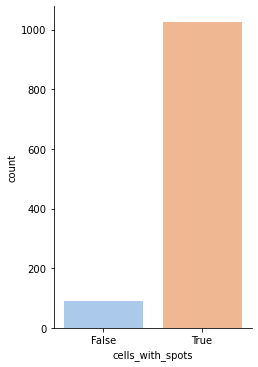

In [50]:
plt.figure(dpi=200)
sh = sns.catplot(data=cell_id, x="cells_with_spots", kind='count', palette="pastel", aspect=0.7)

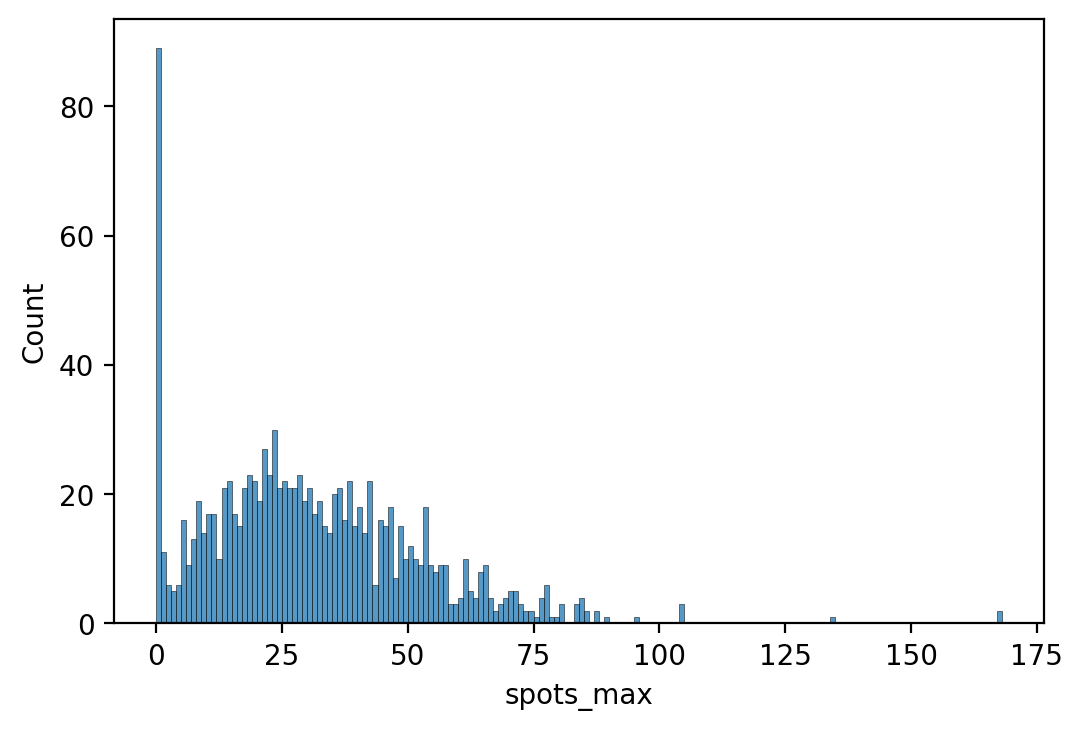

In [72]:
plt.figure(dpi=200)
sh = sns.histplot(cell_id, x="spots_max", binwidth=1)

In [52]:
# plt.figure(dpi=100)
# sh = sns.histplot(data=cell_id, x="spots_sum", binwidth=1)

In [70]:
# cell_id.to_csv('./result/crisprmap20210928Sg2HBNEB.csv', index=False)

In [80]:
cell_id

barcode  correlation_max  correlation_2nd_max  correlation_difference  \
0          -1         0.000000             0.000000                0.000000   
1          -1         0.000000             0.000000                0.000000   
2          -1         0.000000             0.000000                0.000000   
3          -1         0.000000             0.000000                0.000000   
4          -1         0.000000             0.000000                0.000000   
...       ...              ...                  ...                     ...   
1110        8         0.979528             0.549491                0.430037   
1111        9         0.986394             0.575396                0.410997   
1112        2         0.938194             0.721688                0.216506   
1113        9         0.987763             0.571863                0.415900   
1114        1         0.707106             0.000000                0.707106   

      select_by_correlation  spots_max  spots_sum    spots_needed  \
0                     False        0.0        0.0  31395550336760   
1                     False        0.0        0.0  31395550336760   
2                     False        0.0        0.0  31395550336760   
3                     False        0.0        0.0  31395550336760   
4                     False        0.0        0.0  31395550336760   
...                     ...        ...        ...             ...   
1110                   True       21.0       54.0               4   
1111                   True       21.0       36.0               4   
1112                   True        8.0       18.0               5   
1113                   True       11.0       19.0               4   
1114                   True        1.0        1.0              13   

      select_by_spots  cells_with_spots  selected  high_spots  \
0               False             False     False       False   
1               False             False     False       False   
2               False             False     False       False   
3               False             False     False       False   
4               False             False     False       False   
...               ...               ...       ...         ...   
1110             True              True      True       False   
1111             True              True      True       False   
1112             True              True      True       False   
1113             True              True      True       False   
1114            False              True     False       False   

      select_by_high_spots  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
1110                 False  
1111                 False  
1112                 False  
1113                 False  
1114                 False  

[1115 rows x 13 columns]

In [89]:
# df_cell_id = cell_id.copy()
# df_cell_id.loc[df_cell_id.select_by_high_spots == False, 'barcode'] = -1
# df_cell_id
# df_cell_id.to_csv('./result/crisprmap20210928Sg2HBNEB_highSpots.csv', index=False)

In [88]:
# (df_cell_id.barcode==-1).sum() / (df_cell_id.shape[0] -1)

0.4910233393177738

In [85]:
# (df_cell_id.barcode==-1).sum()

547

In [54]:
# high_quality = cell_id[cell_id['correlation_difference']>0.26]
# high_quality_mem = np.zeros(masks_mem.shape)
# for i in high_quality.index:
#     high_quality_mem[np.array(masks_mem)==i] = i
# plt.figure(dpi=250)
# plt.imshow(find_boundaries(high_quality_mem), origin='lower')

In [55]:
# high_quality = cell_id[cell_id['correlation_difference']>0]
# high_quality_mem = np.zeros(masks_mem.shape)
# for i in high_quality.index:
#     high_quality_mem[np.array(masks_mem)==i] = i
# plt.figure(dpi=250)
# plt.imshow(find_boundaries(high_quality_mem[up:down, left:right]), origin='lower', cmap='Greens')
# for i in range(Xthresh.shape[0]):
#     plt.imshow(Xthresh[i, 0], alpha=0.2, origin='lower', cmap="Reds")